In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.3.1
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.3.2
numpy 1.18.4
pandas 1.1.4
sklearn 0.23.2
tensorflow 2.3.1
tensorflow.keras 2.4.0


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

In [4]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
for _ in range(20):
    model.add(keras.layers.Dense(100, activation="selu"))
model.add(keras.layers.AlphaDropout(rate=0.5))
# model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer = keras.optimizers.SGD(0.01),
              metrics = ["accuracy"])

In [5]:
# Tensorboard, ModelCheckpoint, EarlyStopping
# 需要文件夹和文件名
logdir = './dnn-selu-dropout-callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,  "fashion_mnist_weights.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(
        output_model_file, 
        save_best_only = True,
        save_weights_only= True,
    ),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]
history = model.fit(x_train_scaled, y_train, epochs=10,
                    validation_data=(x_valid_scaled, y_valid),
                    callbacks = callbacks)

Epoch 1/10
   1/1719 [..............................] - ETA: 0s - loss: 2.7500 - accuracy: 0.0938WARNING:tensorflow:From /home/meprint/.virtualenvs/tf2_py3/lib/python3.6/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1719/1719 [==============================] - 9s 5ms/step - loss: 0.6959 - accuracy: 0.7619 - val_loss: 0.6404 - val_accuracy: 0.8438
Epoch 2/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4690 - accuracy: 0.8377 - val_loss: 0.5823 - val_accuracy: 0.8516
Epoch 3/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4133 - accuracy: 0.8557 - val_loss: 0.5733 - val_accuracy: 0.8614
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3785 - accuracy: 0.8664 - val_loss: 0.5846 - val_accuracy: 0.8706
Epoch 5/10
1719/1719 [==============

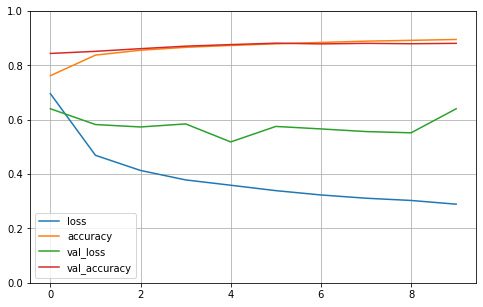

In [6]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

plot_learning_curves(history)

In [7]:
# Loss, accuracy
model.evaluate(x_test_scaled, y_test, verbose=0)

[0.6989180445671082, 0.8700000047683716]

## Load model

In [8]:
loaded_model = keras.models.load_model(output_model_file)
loaded_model.evaluate(x_test_scaled, y_test, verbose=0)

ValueError: No model found in config file.

In [10]:
# 若没有保存模型
model.load_weights(output_model_file)
model.evaluate(x_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.5838 - accuracy: 0.8617


[0.5838469862937927, 0.8616999983787537]

In [11]:
# 直接保存参数
model.save_weights(os.path.join(logdir, "fashion_mnist_weights_2.h5"))